In [114]:
import datetime
import itertools
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import random
from scipy.optimize import minimize
from scipy import linalg
import seaborn as sns

data = pd.read_csv("data/sp500_10.2013-10.2018.csv", index_col="Date")

# # organize DataSeries
# date = data.index
# tLen = len(data)
# time = np.linspace(0, tLen-1, tLen)
# close = [data["Adj Close"][i] for i in range(len(data["Adj Close"]))]
# DataSeries = [time, close]

# matrix helpers
def _yi(price_series):
    return [np.log(p) for p in price_series]

def _fi(tc, m, time_series):
    return [np.power((tc - t), m) for t in time_series]

def _gi(tc, m, w, time_series):
    return [np.power((tc - t), m) * np.cos(w * np.log(tc - t)) for t in time_series]

def _hi(tc, m, w, time_series):
    return [np.power((tc - t), m) * np.sin(w * np.log(tc - t)) for t in time_series]

def _fi_pow_2(tc, m, time_series):
    return np.power(_fi(tc, m, time_series), 2)

def _gi_pow_2(tc, m, w, time_series):
    return np.power(_gi(tc, m, w, time_series), 2)

def _hi_pow_2(tc, m, w, time_series):
    return np.power(_hi(tc, m, w, time_series), 2)

def _figi(tc, m, w, time_series):
    return np.multiply(_fi(tc, m, time_series), _gi(tc, m, w, time_series))

def _fihi(tc, m, w, time_series):
    return np.multiply(_fi(tc, m, time_series), _hi(tc, m, w, time_series))

def _gihi(tc, m, w, time_series):
    return np.multiply(_gi(tc, m, w, time_series), _hi(tc, m, w, time_series))

def _yifi(tc, m, time_series, price_series):
    return np.multiply(_yi(price_series), _fi(tc, m, time_series))

def _yigi(tc, m, w, time_series, price_series):
    return np.multiply(_yi(price_series), _gi(tc, m, w, time_series))

def _yihi(tc, m, w, time_series, price_series):
    return np.multiply(_yi(price_series), _hi(tc, m, w, time_series))

## What I'm trying to do...
I am trying to fit the LPPL model to an S&P 500 dataset using the new fitting method outlined in section IV of [this paper](https://arxiv.org/pdf/1108.0099.pdf). The model can currently be fit to a dataset using a metaheuristic such as taboo search or genetic algorithm. However, in the paper linked to above, the researchers modified the model so as to avoid the use of metaheuristics in fitting the algorithm. Below has more info about the LPPL model; it is paraphrased from the paper.  

Here's where Didier fits it to various market indexes: http://tasmania.ethz.ch/pubfco/fco.html

___

## The LPPL Model
The LPPL model provides a flexible framework to detect bubbles and predict regime changes of a financial asset. A bubble is defined as a faster-than-exponential increase in asset price, that reflects positive feedback loop of higher return anticipations competing with negative feedback spirals of crash expectations. It models a bubble price as a power law with a finite-time singularity decorated by oscillations with a frequency increasing with time. Here is an example of the LPPL model fitted to the Hang Seng Index from ~87-89.


<img src="images/hang_seng_index_87-89.png" alt="Hang Seng Index 87-89" width="500"/>


Here is the model:

$$E[\text{ln }p(t)] = A + B(t_c - t)^m + C(t_c - t)^m cos(\omega ln(t_c - t) - \phi) \tag{1}$$

where:

- $E[\text{ln }p(t)] :=$ expected log price at the date of the termination of the bubble
- $t_c :=$ critical time (date of termination of the bubble and transition in a new regime) 
- $A :=$ expected log price at the peak when the end of the bubble is reached at $t_c$
- $B :=$ amplitude of the power law acceleration
- $C :=$ amplitude of the log-periodic oscillations
- $m :=$ degree of the super exponential growth
- $\omega :=$ scaling ratio of the temporal hierarchy of osciallations
- $\phi :=$ time scale of the oscillations

The model has three components representing a bubble. The first, $A + B(t_c - t)^m$, handles the hyperbolic power law. For $m < 1$ when the price growth becomes unsustainable, and at $t_c$ the growth rate becomes infinite. The second term, $C(t_c - t)^m$, controls the amplitude of the oscillations. It drops to zero at the critical time $t_c$. The third term, $cos(\omega ln(t_c - t) - \phi)$, models the frequency of the osciallations. They become infinite at $t_c$.

___

## Fitting Procedure

The LPPL model has 4 non-linear parameters $(t_c,m,\omega,\phi)$ and 3 linear parameters $(A,B,C)$. They should be chosen with the goal to minimize the difference between the predicted values of the model $ln(\hat{p})$ and the real value $ln(p)$. This repersents a minimization problem with 3 linear and 4 non-linear parameters which have to be found. To decrease complexity of this task, equation (1) is rewritten. For this, two new parameters are introduced:

$$C_1 = C cos\phi, C_2 = C sin\phi \tag{2}$$

and now the equation (1) can be rewritten as:

$$\text{ln }E[p(t)] = A+B(t_c-t)^{m}+C_1(t_c-t)^{m}cos(\omega ln(t_c-t))+C_2(t_c-t)^{m} sin(\omega ln(t_c-t)) \tag{3}$$

$$E[\text{ln }p(t)] = A + (t_c - t)^m\bigl(B + C_1\text{cos}(\omega\text{ ln}(t_c - t)) + C_2\text{sin}(\omega\text{ ln}(t_c - t))\bigr)$$

By doing so, the model (3) now has 3 non-linear $(t_c,\omega,m)$ and 4 linear parameters $(A,B,C_1,C_2)$. To estimate the parameters which are fitted to the time series the least squares method with the following cost function (4) is used.

$$F(t_c,m,\omega,A,B,C_1,C_2) = \sum_{i=1}^{N} \left[\text{ln }p(\tau_{i}) - A - B(t_c-\tau_{i})^{m} - C_1(t_c-\tau_{i})^{m} cos(\omega ln(t_c-\tau_{i})) - C_2(t_c-\tau_{i})^{m} sin(\omega ln(t_c-\tau_{i}))\right]^{2} \tag{4}$$

where:

- $\tau_1 = t_1$
- $\tau_N = t_2$

Slaving the 4 linear parameters $A, B, C_1, C_2$ to the 3 nonlinear $t_c, \omega, m$ we obtain the nonlinear
optimization problem

$$\{\hat{t_c},\hat{m},\hat{\omega}\} = arg \min\limits_{t_c,m,\omega} F_1(t_c,m,\omega), \tag{5}$$

where the cost function $F_1(t_c,m,\omega)$ is given by

$$F_1(t_c,m,\omega) = \min\limits_{A,B,C_1,C_2} F(t_c,m,\omega,A,B,C_1,C_2) \tag{6}$$ 

The optimization problem $(\{\hat{A},\hat{B},\hat{C_1},\hat{C_2}\} = \text{arg} \min_{A,B,C_1,C_2} F(t_c,m,\omega,A,B,C_1,C_2))$ has a unique solution obtained from the matrix equation:


$$
    \begin{pmatrix}
        N & \sum{f_i} & \sum{g_i} & \sum{h_i}\\ 
        \sum{f_i} & \sum{f_i^{2}} & \sum{f_i g_i} & \sum{f_i h_i}\\
        \sum{g_i} & \sum{f_i g_i} & \sum{g_i^{2}} & \sum{g_i h_i}\\
        \sum{h_i} & \sum{f_i h_i} & \sum{g_i h_i} & \sum{h_i^{2}}\\
    \end{pmatrix}
    \begin{pmatrix}
        \hat{A}\\ 
        \hat{B}\\
        \hat{C_1}\\
        \hat{C_2}\\
    \end{pmatrix}
    =
    \begin{pmatrix}
        \sum{y_i}\\ 
        \sum{y_i f_i}\\
        \sum{y_i g_i}\\
        \sum{y_i h_i}\\
    \end{pmatrix}
    \tag{7}
$$

where:

- $y_i = \text{ln } p(\tau_i)$
- $f_i = (t_c - \tau_i)^{m}$
- $g_i = (t_c - \tau_i)^{m} cos(\omega \text{ln }(t_c-\tau_i))$
- $h_i = (t_c - \tau_i)^{m} sin(\omega \text{ln }(t_c-\tau_i))$
    
___

## Calculating DS LPPLS Confidence and Trust

Read [this paper](https://poseidon01.ssrn.com/delivery.php?ID=886002089031003126088000123088125073000064069010066071005099075108005021123027065112038036026000062033037025111099068083077066116075088062023085069092065114121103030019004113096099018080065089111005114031019075066017087004024006118111004092109002101&EXT=pdf) to figure out how to use this fit to make a prediction.

## Here's what I have so far...

In [115]:
# revised version of the LPPL without φ
# found on page 11 as equation (13)
def lppl(t, tc, m, w, a, b, c1, c2):
    # print("tc: {}\nm: {}\nw: {}\na: {}\nb: {}\nc1: {}\nc2: {}\n-------------".format(tc,m,w,a,b,c1,c2))
    return a + np.power(tc - t, m) * (b + ((c1 * np.cos(w * np.log(tc - t))) + (c2 * np.sin(w * np.log(tc - t)))))


# The distance to the critical time is τ = tc − t for bubbles and τ = t − tc for antibubbles.
def lppl_antibubble(t, tc, m, w, a, b, c1, c2):
    return a + np.power(t - tc, m) * (b + ((c1 * np.cos(w * np.log(t - tc))) + (c2 * np.sin(w * np.log(t - tc)))))


# finds the least square difference
def func_restricted(x, *args):
    tc = x[0]
    m  = x[1]
    w  = x[2]
    
    data_series = args[0]
    
    lin_vals = matrix_equation(tc, m, w, data_series)
    
    a  = lin_vals[0] 
    b  = lin_vals[1]
    c1 = lin_vals[2] 
    c2 = lin_vals[3]
    
    delta = [lppl(t, tc, m, w, a, b, c1, c2) for t in data_series[0]]
    delta = np.subtract(delta, data_series[1])
    delta = np.power(delta, 2)
    return np.sum(delta)


# solve the matrix equation
def matrix_equation(tc, m, w, data_series):
    time_series = data_series[0]
    price_series = data_series[1]
    N  = len(price_series)
    
    fi = np.sum(_fi(tc, m, time_series))
    gi = np.sum(_gi(tc, m, w, time_series))
    hi = np.sum(_hi(tc, m, w, time_series))
    
    fi_pow_2 = np.sum(_fi_pow_2(tc, m, time_series))
    gi_pow_2 = np.sum(_gi_pow_2(tc, m, w, time_series))
    hi_pow_2= np.sum(_hi_pow_2(tc, m, w, time_series))
    
    figi = np.sum(_figi(tc, m, w, time_series))
    fihi = np.sum(_fihi(tc, m, w, time_series))
    gihi = np.sum(_gihi(tc, m, w, time_series))
    
    yi = np.sum(_yi(price_series))
    yifi = np.sum(_yifi(tc, m, time_series, price_series))
    yigi = np.sum(_yigi(tc, m, w, time_series, price_series))
    yihi = np.sum(_yihi(tc, m, w, time_series, price_series))
    
    matrix_1 = np.matrix([
        [N,  fi,       gi,       hi      ],
        [fi, fi_pow_2, figi,     fihi    ],
        [gi, figi,     gi_pow_2, gihi    ],
        [hi, fihi,     gihi,     hi_pow_2]
    ])
    
    matrix_2 = np.matrix([
        [yi],
        [yifi],
        [yigi],
        [yihi]
    ])
    
    product = np.linalg.solve(matrix_1, matrix_2)
    
    return [i[0] for i in product.tolist()]

/Users/josheejames/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in power
/Users/josheejames/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in power
/Users/josheejames/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in log
/Users/josheejames/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in power
/Users/josheejames/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in log
/Users/josheejames/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """
/Users/josheejames/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


Success: True
Message: Optimization terminated successfully.
Number of iterations: 88
Number of evaluations of obj funcs: 162
-------------------------
iteration 0: 750 trading days
[{'ds_lppls_confidence': True, 'cof': array([749.00004373,   1.05340942,   9.06026256])}]
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: True
Message: Optimization terminated successfully.
Number of iterations: 89
Number of evaluations of obj funcs: 178
-------------------------
iteration 1: 745 trading days
[{'ds_lppls_confidence': True, 'cof': array([749.00004373,   1.05340942,   9.06026256])}, {'ds_lppls_confidence': False, 'cof': array([963.18667052,   1.05511259,  14.79924329])}]
Success: True
Mess

Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 248
Number of evaluations of obj funcs: 600
-------------------------
Success: True
Message: Optimization terminated successfully.
Number of iterations: 257
Number of evaluations of obj funcs: 469
-------------------------
iteration 10: 700 trading days
[{'ds_lppls_confidence': True, 'cof': array([749.00004373,   1.05340942,   9.06026256])}, {'ds_lppls_confidence': False, 'cof': array([963.18667052,   1.05511259,  14.79924329])}, {'ds_lppls_confidence': False, 'cof': array([974.63182282,   1.1010715 ,  15.5616376 ])}, {'ds_lppls_confidence': True, 'cof': array([744.79793071,   1.12528894,  10.00032786])}, {'ds_lppls_confidence': False, 'cof': array([ 2.88991013e+03,  2.05074923e-01, -3.94720913e-02])}, {'ds_lppls_confidence': False, 'cof': array([724.00000044,   1.29431253,   4.59215191])}, {'ds_lppls_confidence': False, 'cof': array([766.58374365,   1.37274853,   5.73528513])}, {'ds

Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: True
Message: Optimization terminated successfully.
Number of iterations: 101
Number of evaluations of obj funcs: 205
-------------------------
iteration 16: 670 trading days
[{'ds_lppls_confidence': True, 'cof': array([749.00004373,   1.05340942,   9.06026256])}, {'ds_lppls_confidence': False, 'cof': array([963.18667052,   1.05511259,  14.79924329])}, {'ds_lppls_confidence': False, 'cof': array([974.63182282,   1.1010715 ,  15.5616376 ])}, {'ds_lppls_confidence': True, 'cof': array([744.79793071,   1.12528894,  10.00032786])}, {'ds_lppls_confidence': False, 'cof': array([ 2.88991013e+03,  2.05074923e-01, -3.94720913e-02])}, {'ds_lppls

/Users/josheejames/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Success: True
Message: Optimization terminated successfully.
Number of iterations: 111
Number of evaluations of obj funcs: 222
-------------------------
iteration 20: 650 trading days
[{'ds_lppls_confidence': True, 'cof': array([749.00004373,   1.05340942,   9.06026256])}, {'ds_lppls_confidence': False, 'cof': array([963.18667052,   1.05511259,  14.79924329])}, {'ds_lppls_confidence': False, 'cof': array([974.63182282,   1.1010715 ,  15.5616376 ])}, {'ds_lppls_confidence': True, 'cof': array([744.79793071,   1.12528894,  10.00032786])}, {'ds_lppls_confidence': False, 'cof': array([ 2.88991013e+03,  2.05074923e-01, -3.94720913e-02])}, {'ds_lppls_confidence': False, 'cof': array([724.00000044,   1.29431253,   4.59215191])}, {'ds_lppls_confidence': False, 'cof': array([766.58374365,   1.37274853,   5.73528513])}, {'ds_lppls_confidence': False, 'cof': array([714.00000117,   1.35075041,   5.00816996])}, {'ds_lppls_confidence': False, 'cof': array([778.63779534,   1.46227906,   6.5849648 ])}

Success: True
Message: Optimization terminated successfully.
Number of iterations: 174
Number of evaluations of obj funcs: 327
-------------------------
iteration 24: 630 trading days
[{'ds_lppls_confidence': True, 'cof': array([749.00004373,   1.05340942,   9.06026256])}, {'ds_lppls_confidence': False, 'cof': array([963.18667052,   1.05511259,  14.79924329])}, {'ds_lppls_confidence': False, 'cof': array([974.63182282,   1.1010715 ,  15.5616376 ])}, {'ds_lppls_confidence': True, 'cof': array([744.79793071,   1.12528894,  10.00032786])}, {'ds_lppls_confidence': False, 'cof': array([ 2.88991013e+03,  2.05074923e-01, -3.94720913e-02])}, {'ds_lppls_confidence': False, 'cof': array([724.00000044,   1.29431253,   4.59215191])}, {'ds_lppls_confidence': False, 'cof': array([766.58374365,   1.37274853,   5.73528513])}, {'ds_lppls_confidence': False, 'cof': array([714.00000117,   1.35075041,   5.00816996])}, {'ds_lppls_confidence': False, 'cof': array([778.63779534,   1.46227906,   6.5849648 ])}

/Users/josheejames/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in power
/Users/josheejames/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in power
/Users/josheejames/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in power
/Users/josheejames/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in multiply
/Users/josheejames/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/Users/josheejames/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: overflow encountered in multiply
/Users/josheejames/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: overflow encountered in multiply


Success: True
Message: Optimization terminated successfully.
Number of iterations: 171
Number of evaluations of obj funcs: 328
-------------------------
iteration 27: 615 trading days
[{'ds_lppls_confidence': True, 'cof': array([749.00004373,   1.05340942,   9.06026256])}, {'ds_lppls_confidence': False, 'cof': array([963.18667052,   1.05511259,  14.79924329])}, {'ds_lppls_confidence': False, 'cof': array([974.63182282,   1.1010715 ,  15.5616376 ])}, {'ds_lppls_confidence': True, 'cof': array([744.79793071,   1.12528894,  10.00032786])}, {'ds_lppls_confidence': False, 'cof': array([ 2.88991013e+03,  2.05074923e-01, -3.94720913e-02])}, {'ds_lppls_confidence': False, 'cof': array([724.00000044,   1.29431253,   4.59215191])}, {'ds_lppls_confidence': False, 'cof': array([766.58374365,   1.37274853,   5.73528513])}, {'ds_lppls_confidence': False, 'cof': array([714.00000117,   1.35075041,   5.00816996])}, {'ds_lppls_confidence': False, 'cof': array([778.63779534,   1.46227906,   6.5849648 ])}

Singular matrix
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Singular matrix
Success: True
Message: Optimization terminated successfully.
Number of iterations: 90
Number of evaluations of obj funcs: 177
-------------------------
iteration 30: 600 trading days
[{'ds_lppls_confidence': True, 'cof': array([749.00004373,   1.05340942,   9.06026256])}, {'ds_lppls_confidence': False, 'cof': array([963.18667052,   1.05511259,  14.79924329])}, {'ds_lppls_confidence': False, 'cof': array([974.63182282,   1.1010715 ,  15.5616376 ])}, {'ds_lppls_confidence': True, 'cof': array([744.79793071,   1.12528894,  10.00032786])}, {'ds_lppls_confidence': False, 'cof': array([ 2.88991013e+03,  2.05074923e-01, -3.94720913e-02])}, {'ds_lppls_confidence': False, 'cof': array([724.00000044,   1.29431253,   4.59215191])}, {'ds_lppls_confidence': False, 'cof': array([766.58374365,   1.

Singular matrix
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: True
Message: Optimization terminated successfully.
Number of iterations: 100
Number of evaluations of obj funcs: 199
-------------------------
iteration 33: 585 trading days
[{'ds_lppls_confidence': True, 'cof': array([749.00004373,   1.05340942,   9.06026256])}, {'ds_lppls_confidence': False, 'cof': array([963.18667052,   1.05511259,  14.79924329])}, {'ds_lppls_confidence': False, 'cof': array([974.63182282,   1.1010715 ,  15.5616376 ])}, {'ds_lppls_confidence': True, 'cof': array([744.79793071,   1.12528894,  10.00032786])}, {'ds_lppls_confidence': False, 'cof': array([ 2.88991013e+03,  2.05074923e-01, -3.94720913e-0

Singular matrix


/Users/josheejames/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


Success: True
Message: Optimization terminated successfully.
Number of iterations: 197
Number of evaluations of obj funcs: 387
-------------------------
iteration 36: 570 trading days
[{'ds_lppls_confidence': True, 'cof': array([749.00004373,   1.05340942,   9.06026256])}, {'ds_lppls_confidence': False, 'cof': array([963.18667052,   1.05511259,  14.79924329])}, {'ds_lppls_confidence': False, 'cof': array([974.63182282,   1.1010715 ,  15.5616376 ])}, {'ds_lppls_confidence': True, 'cof': array([744.79793071,   1.12528894,  10.00032786])}, {'ds_lppls_confidence': False, 'cof': array([ 2.88991013e+03,  2.05074923e-01, -3.94720913e-02])}, {'ds_lppls_confidence': False, 'cof': array([724.00000044,   1.29431253,   4.59215191])}, {'ds_lppls_confidence': False, 'cof': array([766.58374365,   1.37274853,   5.73528513])}, {'ds_lppls_confidence': False, 'cof': array([714.00000117,   1.35075041,   5.00816996])}, {'ds_lppls_confidence': False, 'cof': array([778.63779534,   1.46227906,   6.5849648 ])}

Success: True
Message: Optimization terminated successfully.
Number of iterations: 102
Number of evaluations of obj funcs: 209
-------------------------
iteration 39: 555 trading days
[{'ds_lppls_confidence': True, 'cof': array([749.00004373,   1.05340942,   9.06026256])}, {'ds_lppls_confidence': False, 'cof': array([963.18667052,   1.05511259,  14.79924329])}, {'ds_lppls_confidence': False, 'cof': array([974.63182282,   1.1010715 ,  15.5616376 ])}, {'ds_lppls_confidence': True, 'cof': array([744.79793071,   1.12528894,  10.00032786])}, {'ds_lppls_confidence': False, 'cof': array([ 2.88991013e+03,  2.05074923e-01, -3.94720913e-02])}, {'ds_lppls_confidence': False, 'cof': array([724.00000044,   1.29431253,   4.59215191])}, {'ds_lppls_confidence': False, 'cof': array([766.58374365,   1.37274853,   5.73528513])}, {'ds_lppls_confidence': False, 'cof': array([714.00000117,   1.35075041,   5.00816996])}, {'ds_lppls_confidence': False, 'cof': array([778.63779534,   1.46227906,   6.5849648 ])}

Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 200
Number of evaluations of obj funcs: 601
-------------------------
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 238
Number of evaluations of obj funcs: 602
-------------------------


KeyboardInterrupt: 

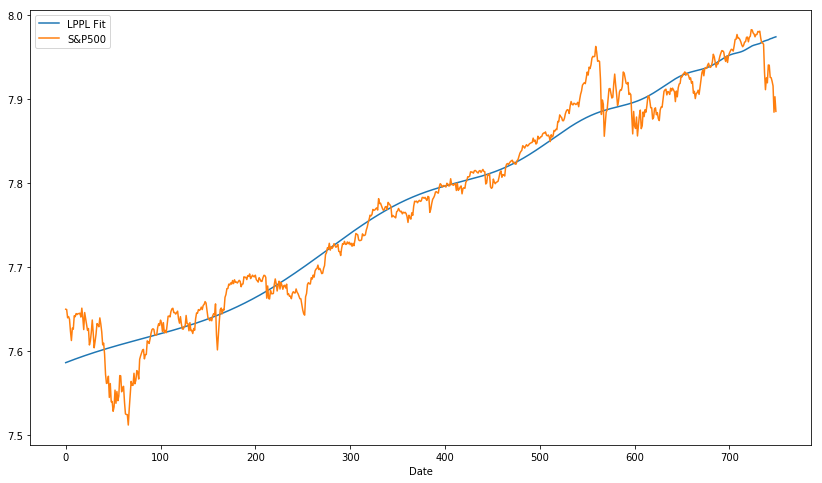

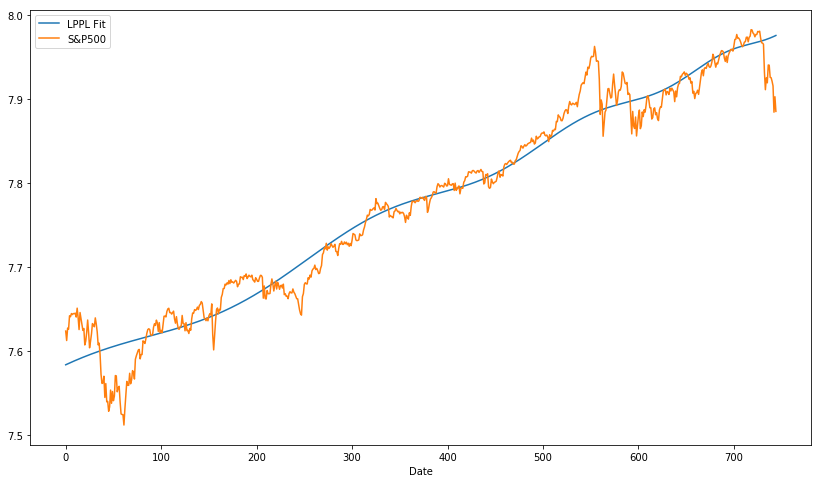

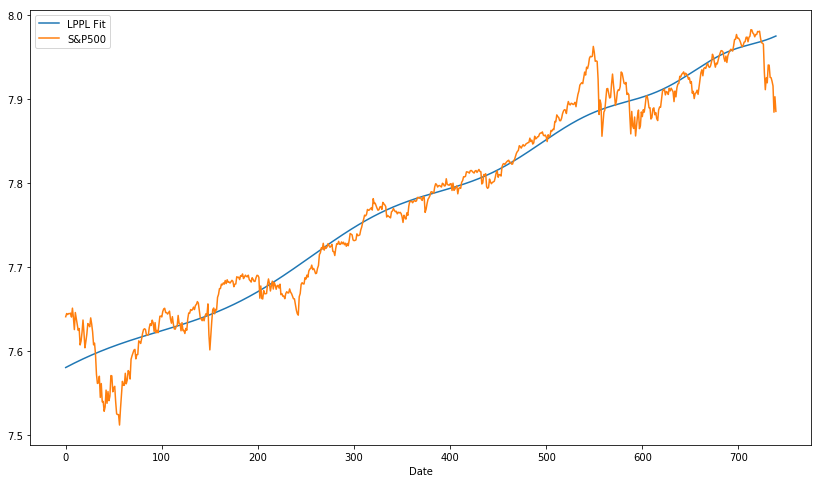

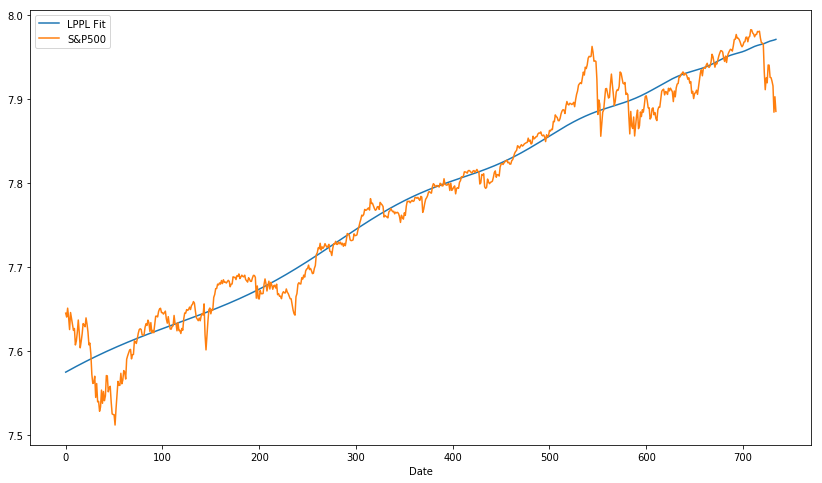

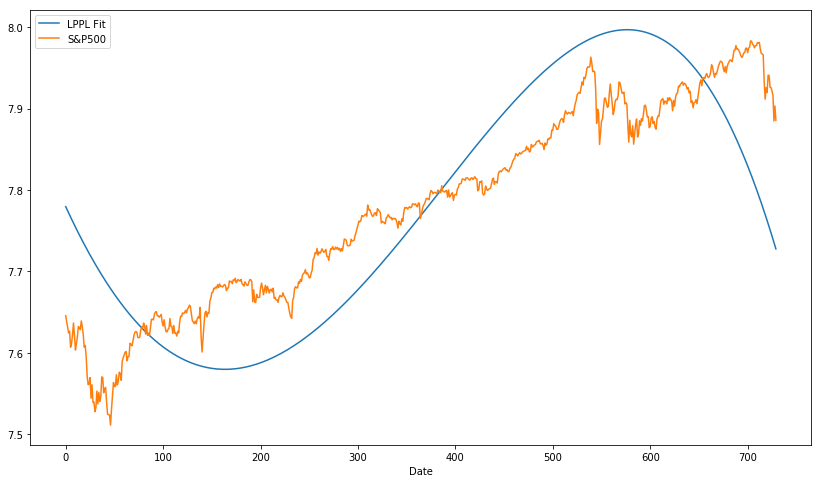

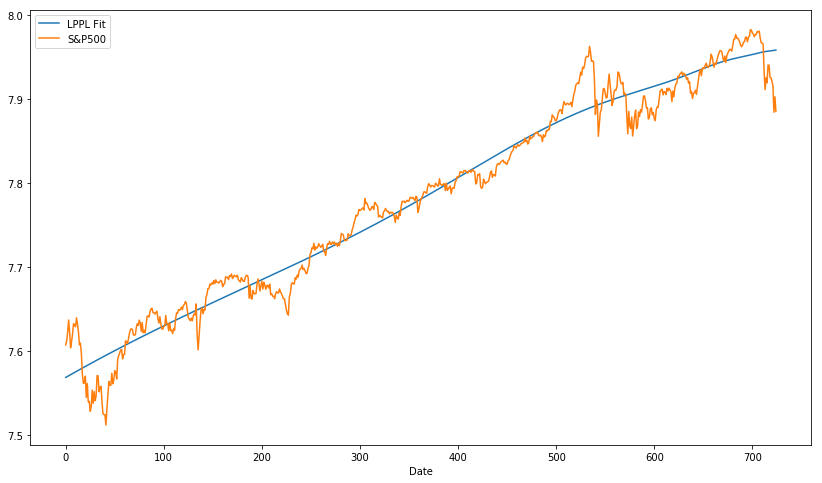

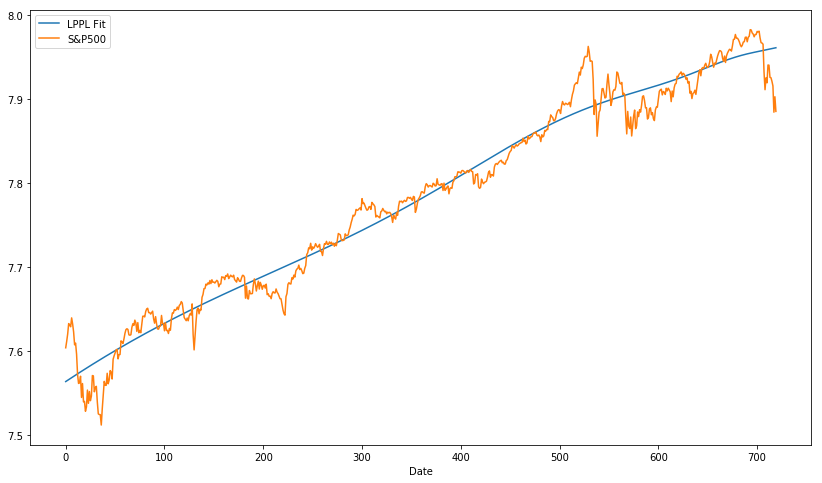

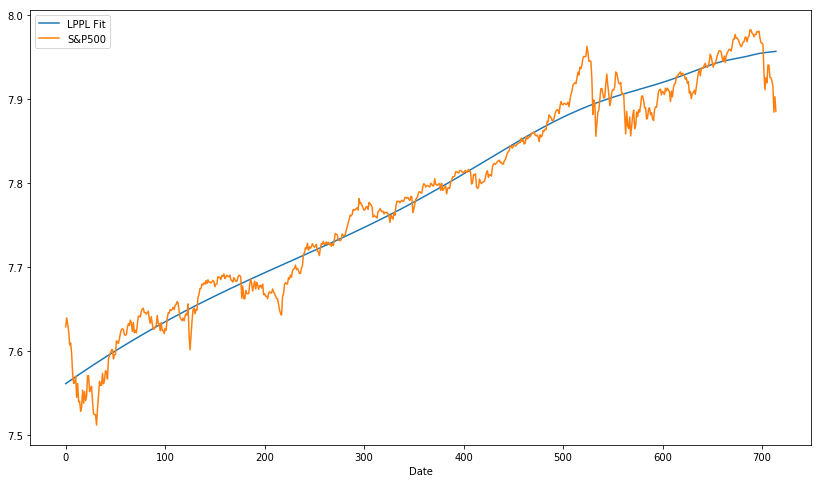

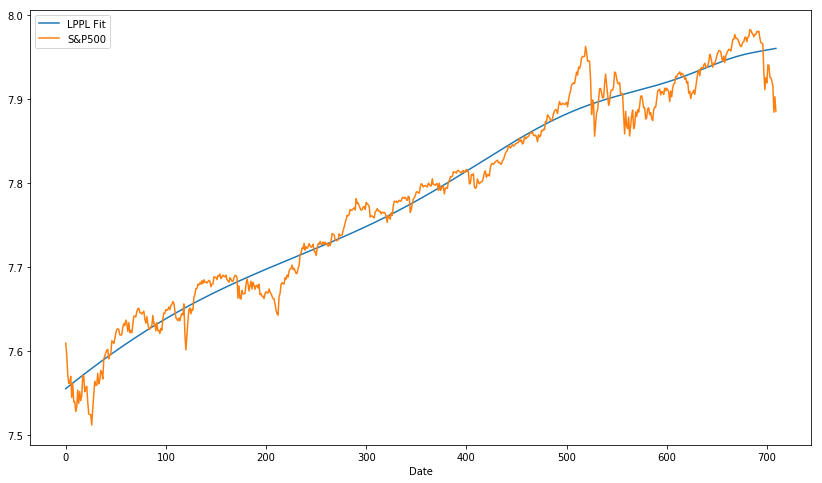

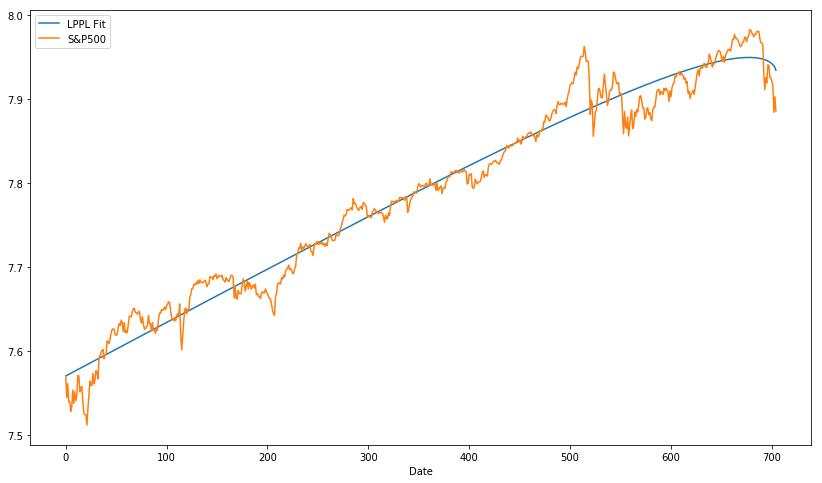

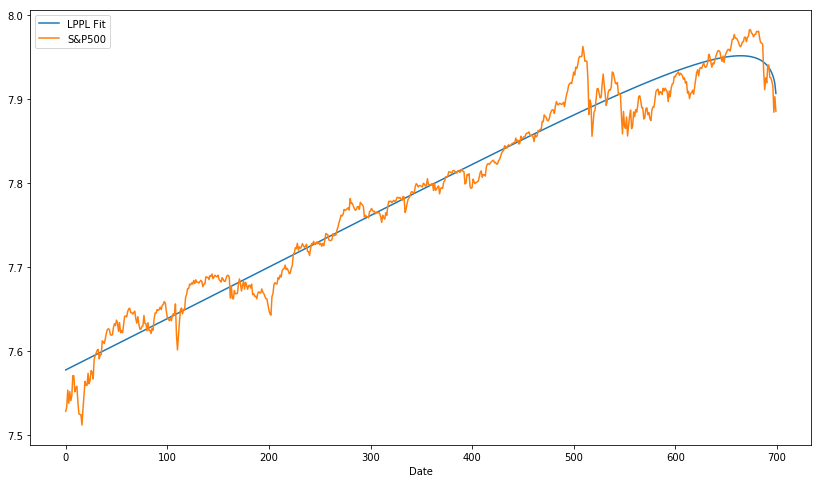

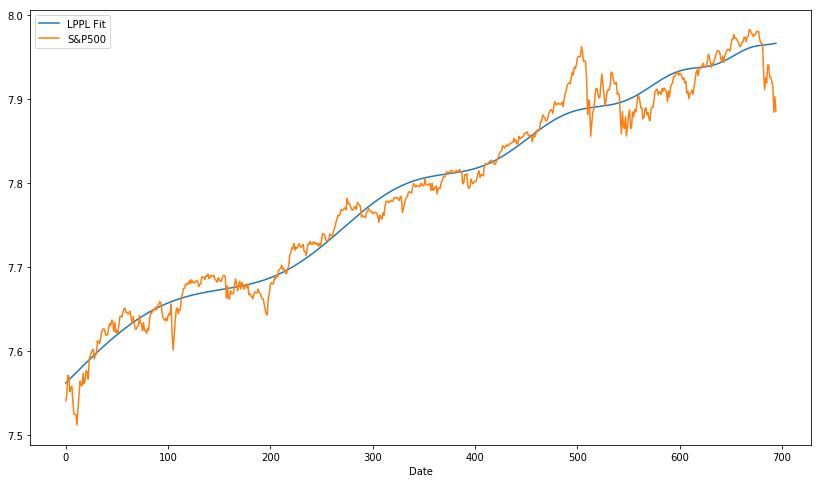

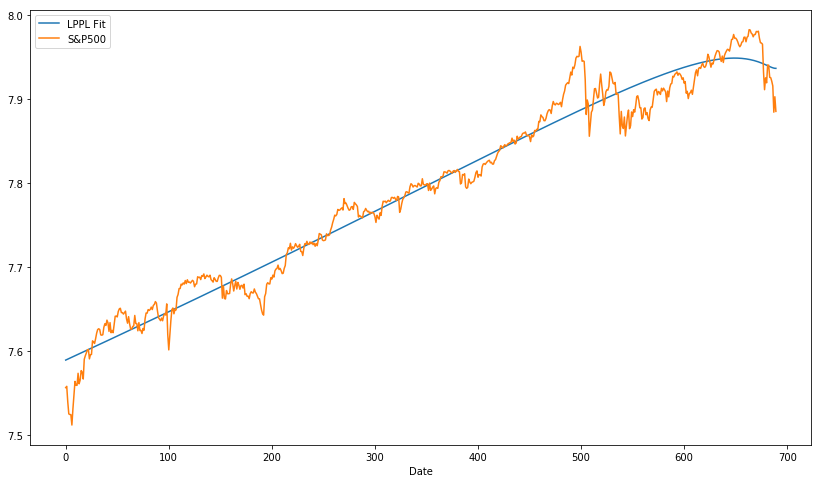

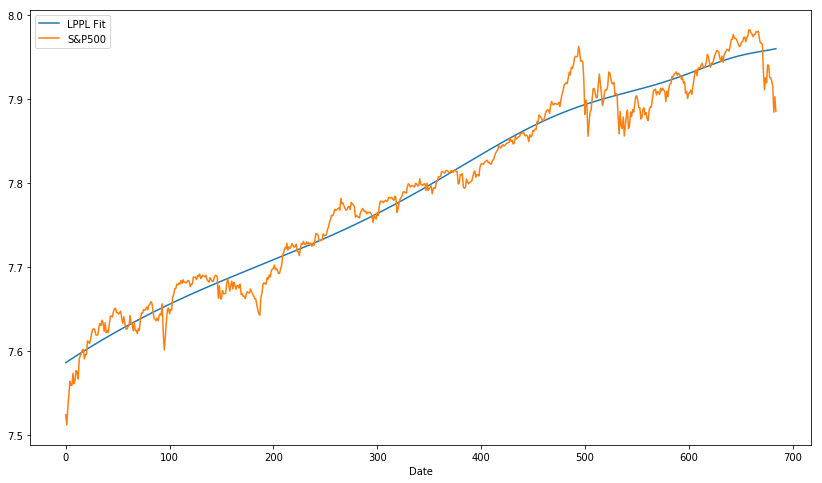

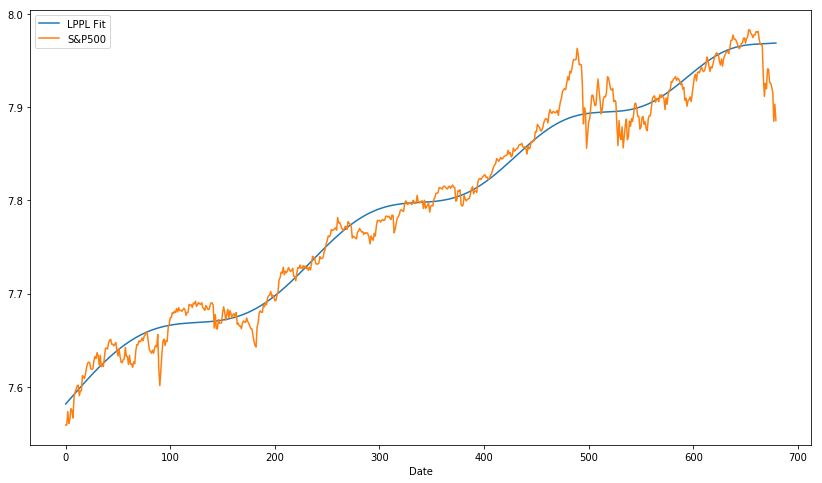

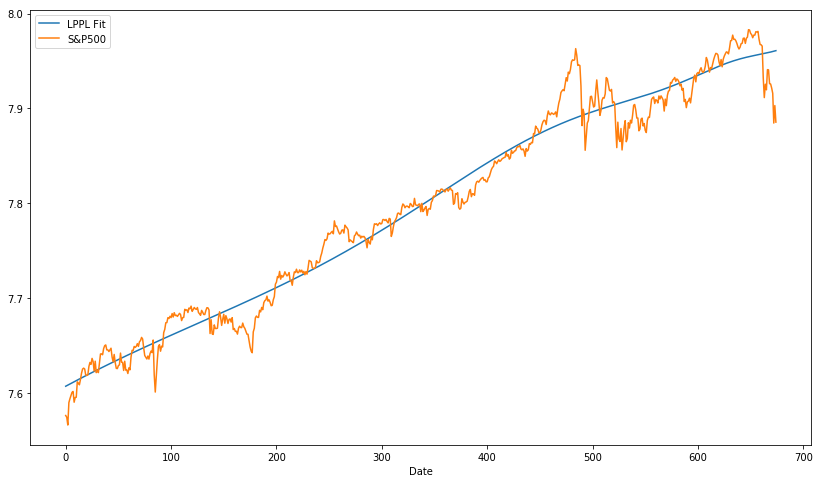

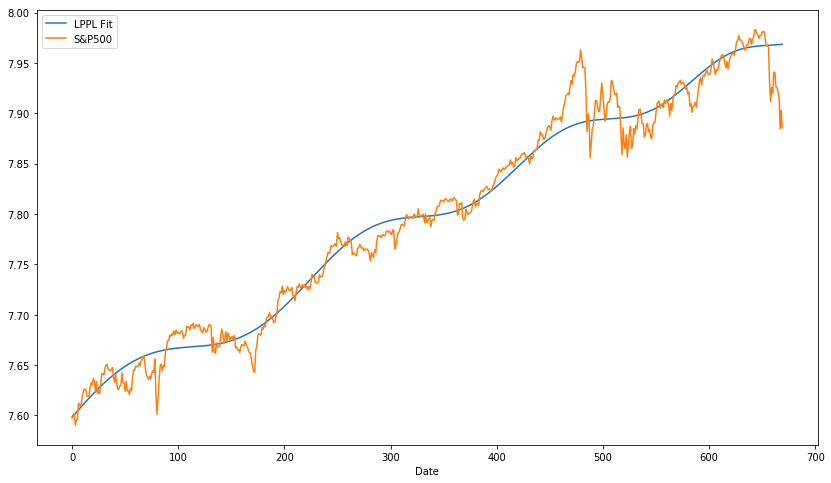

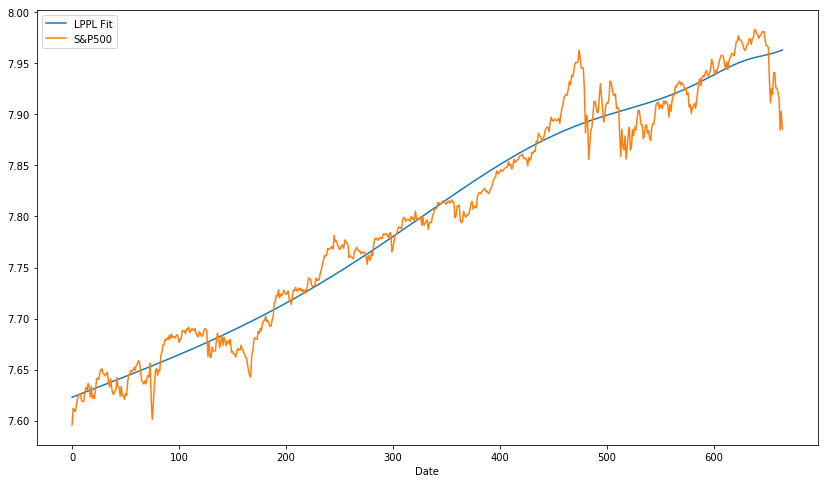

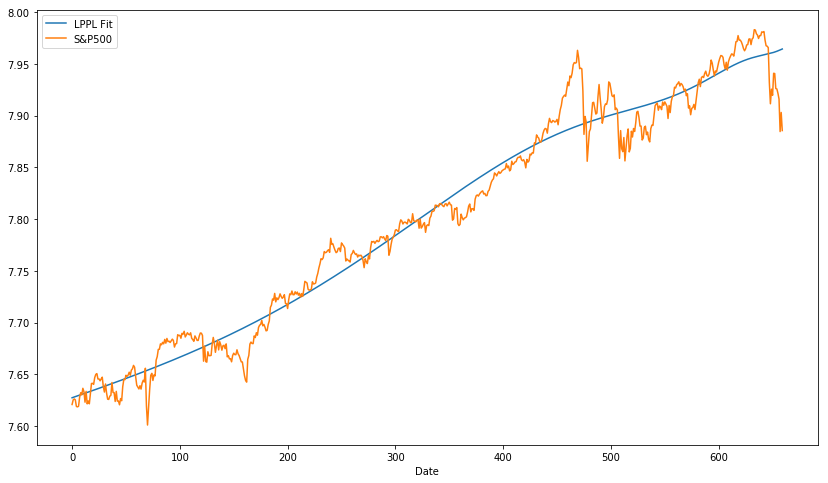

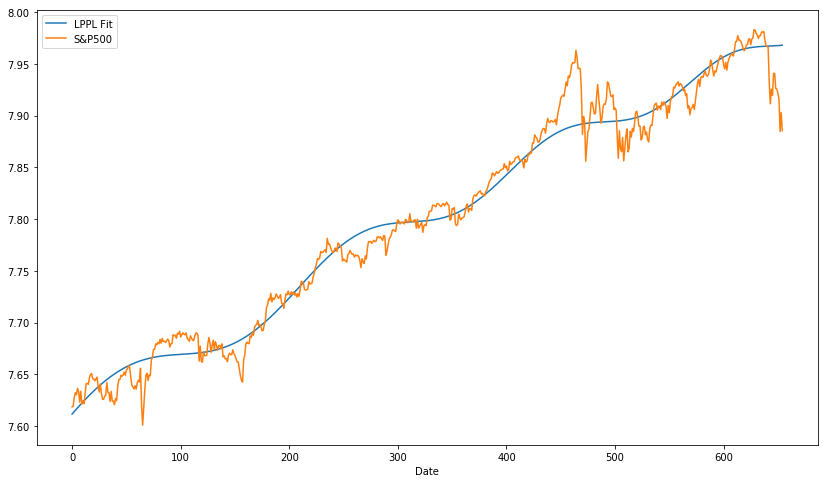

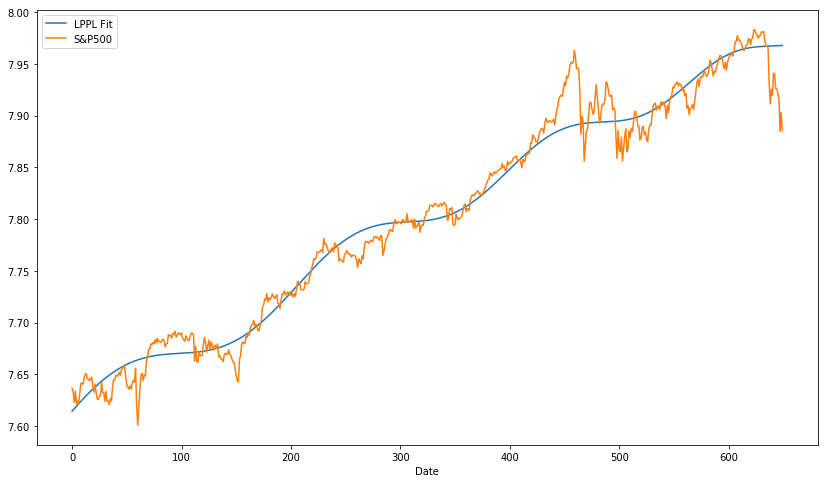

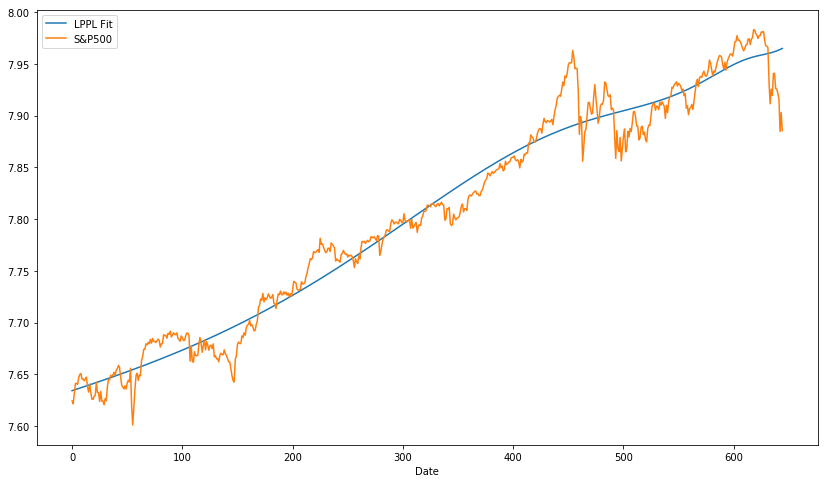

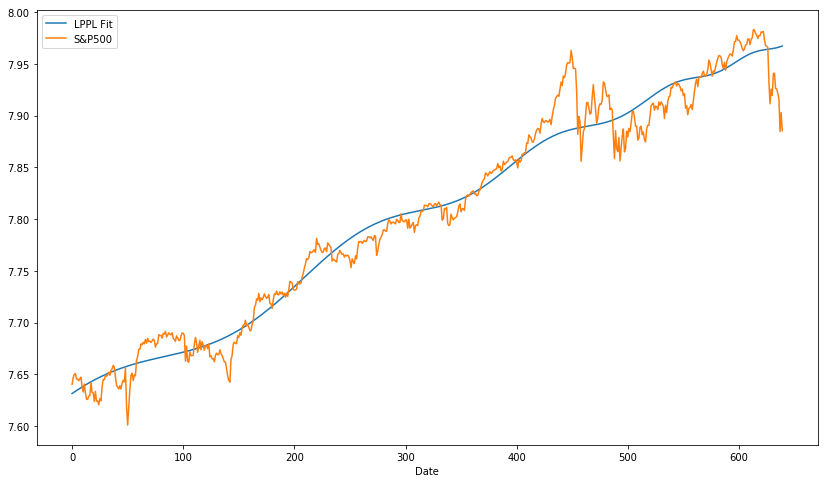

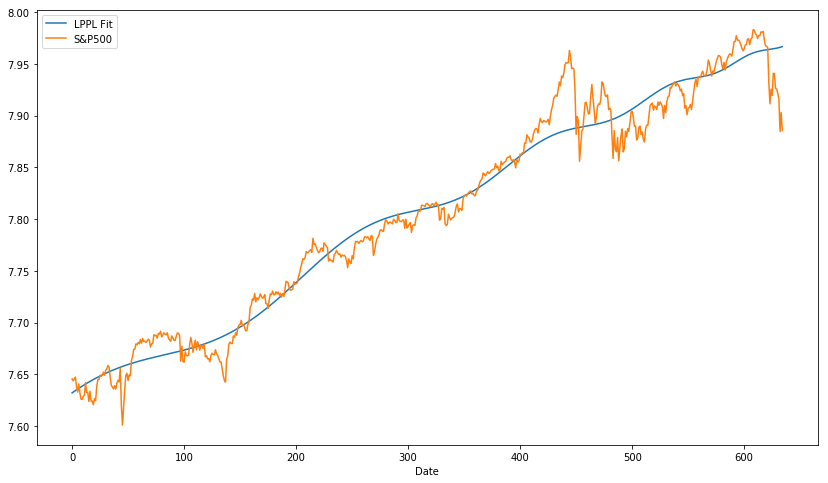

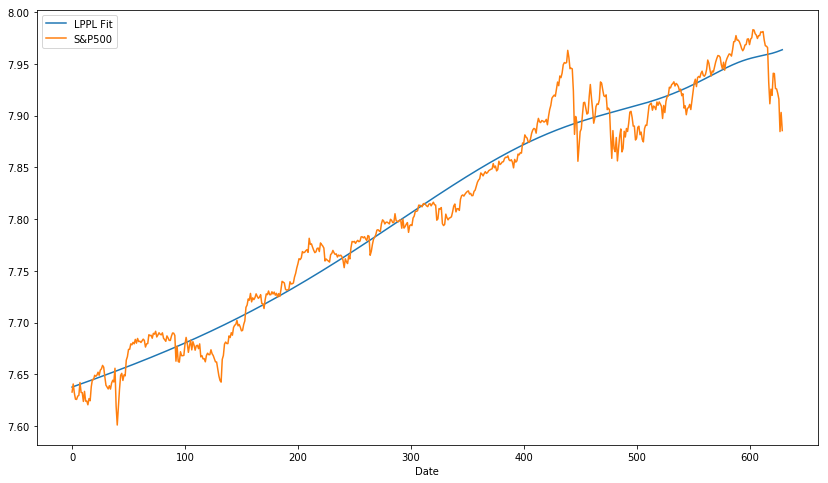

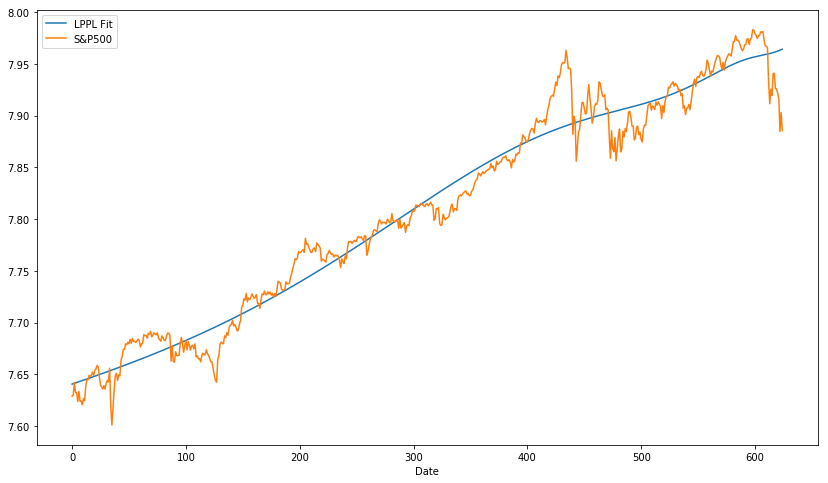

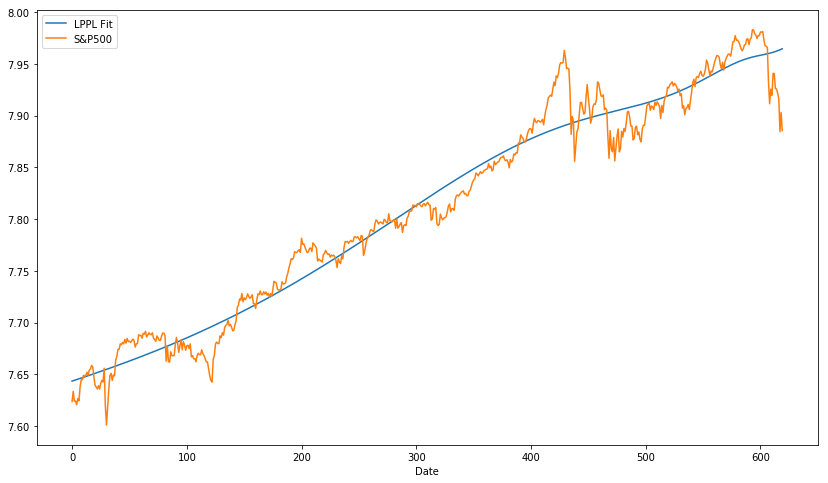

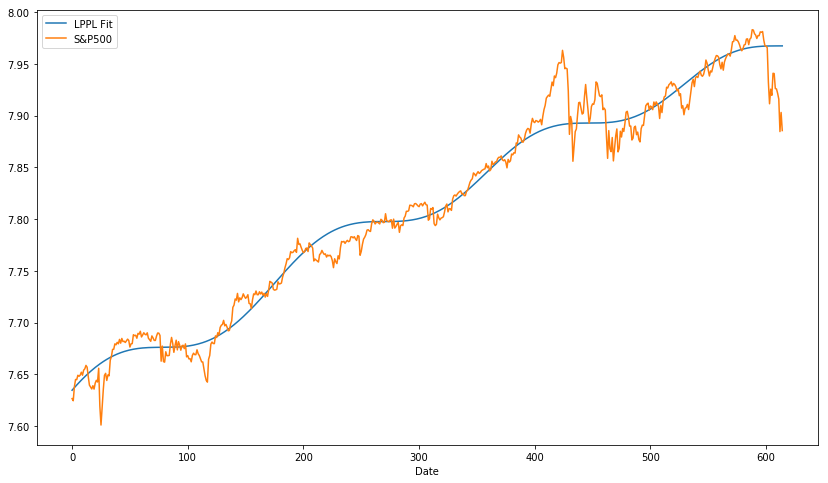

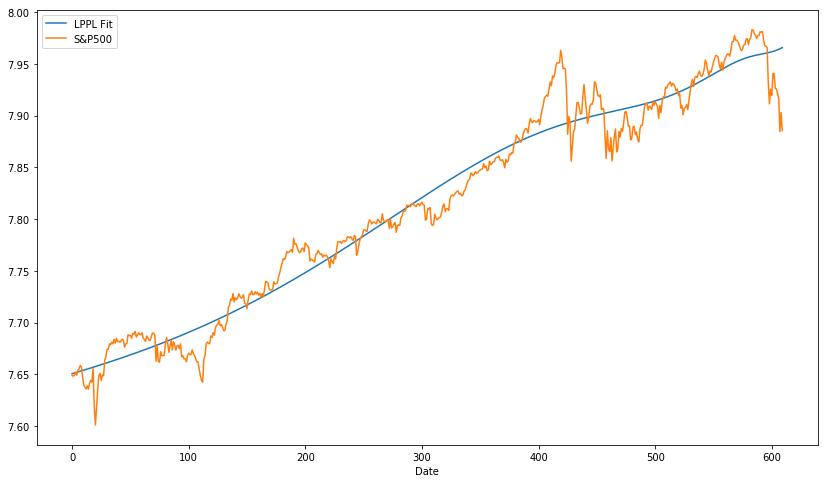

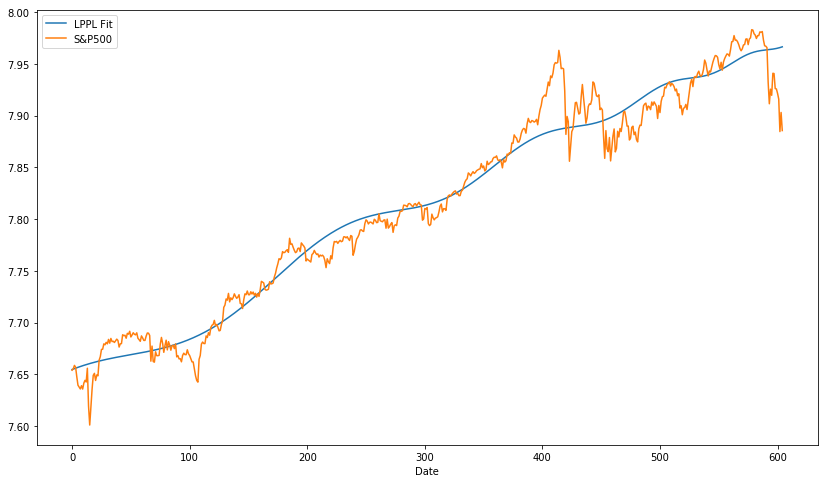

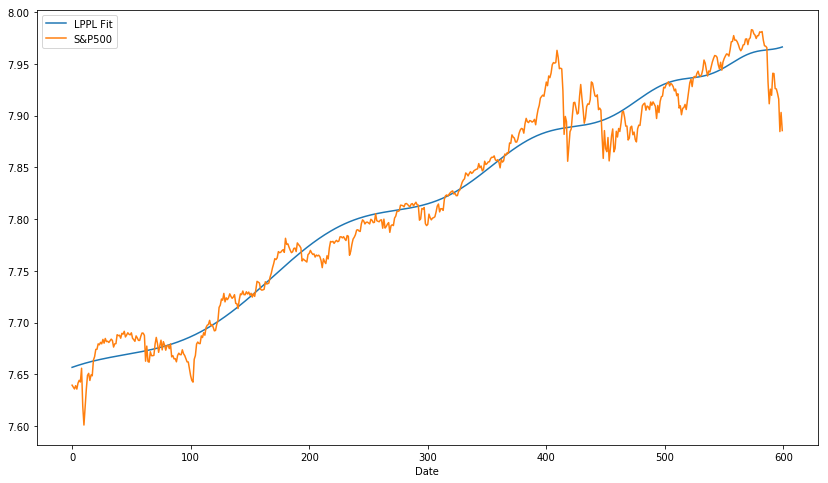

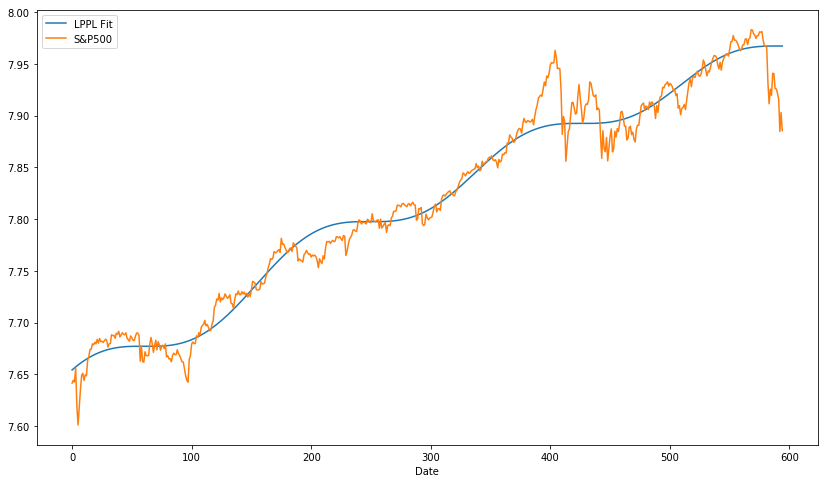

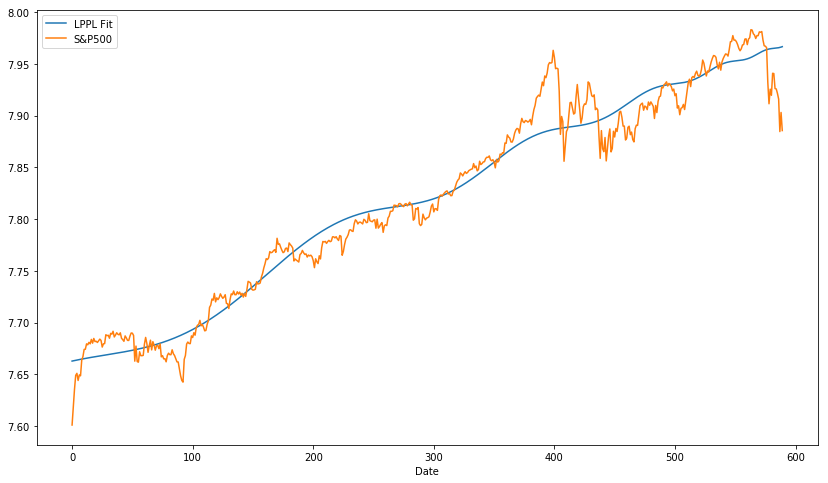

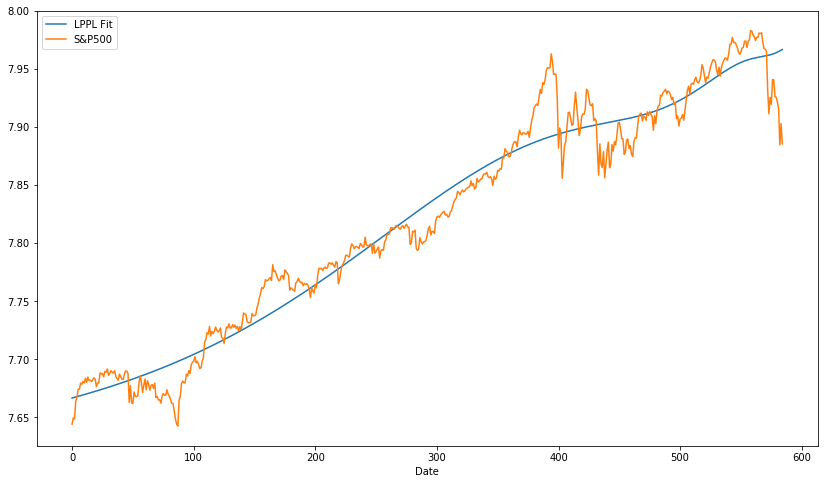

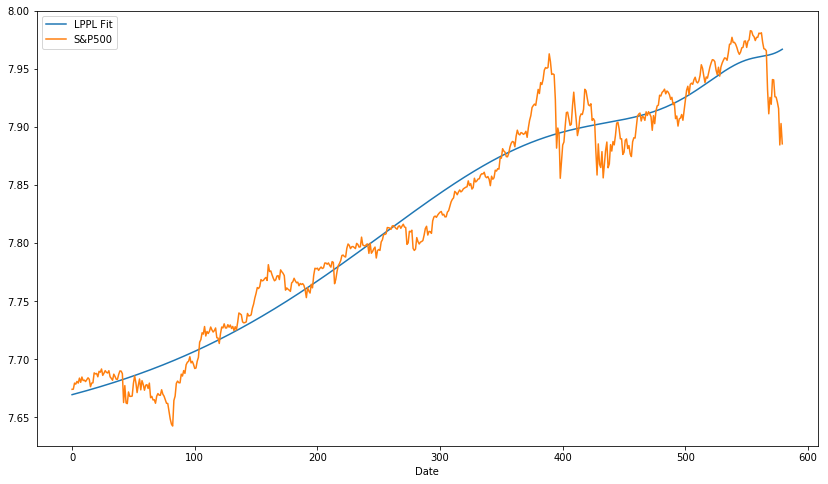

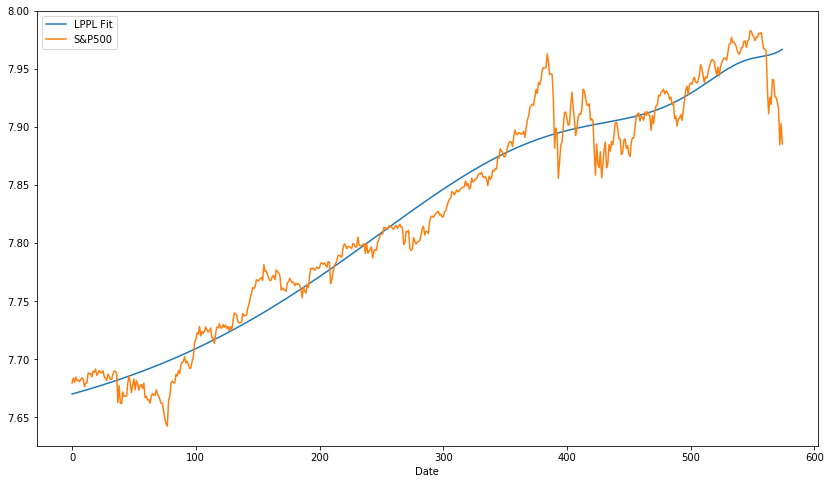

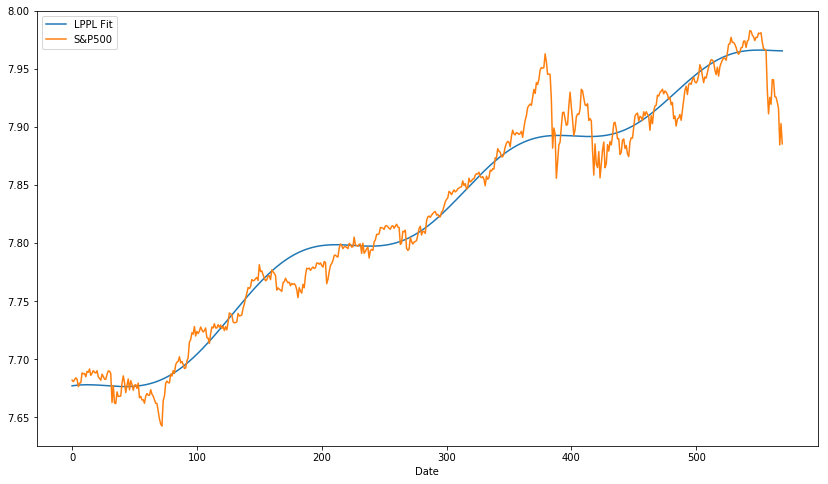

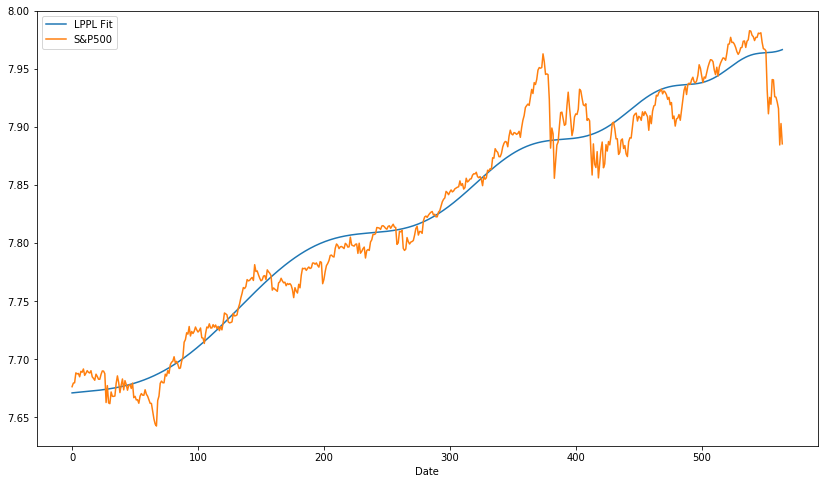

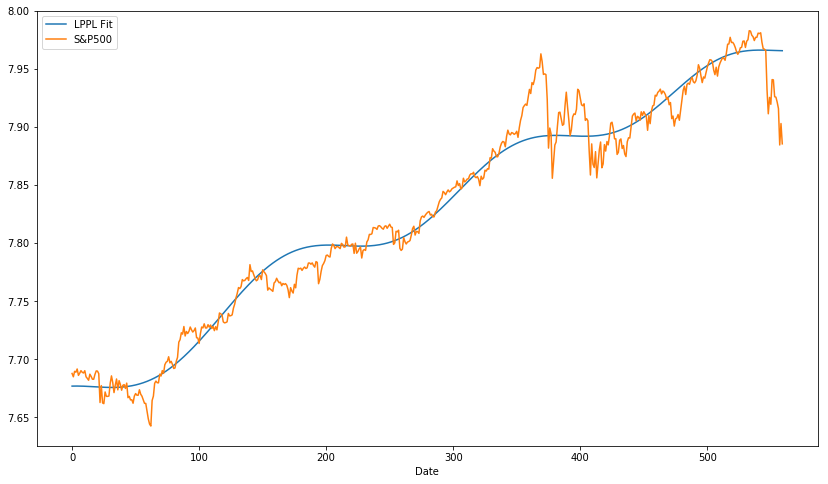

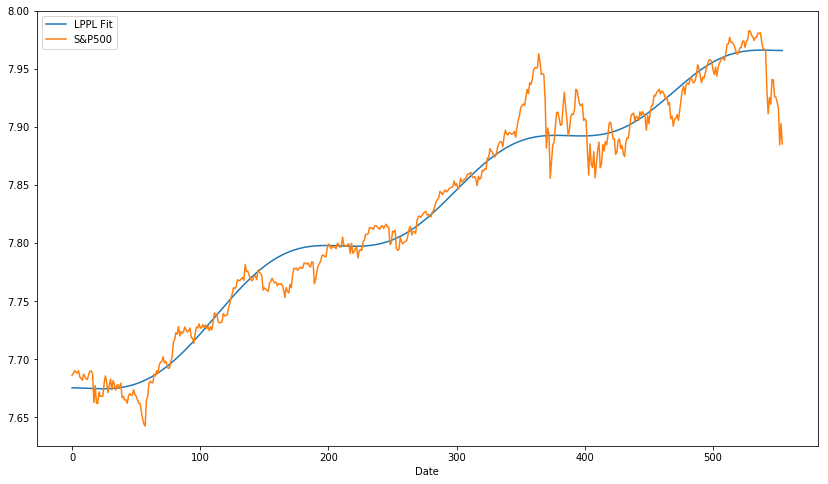

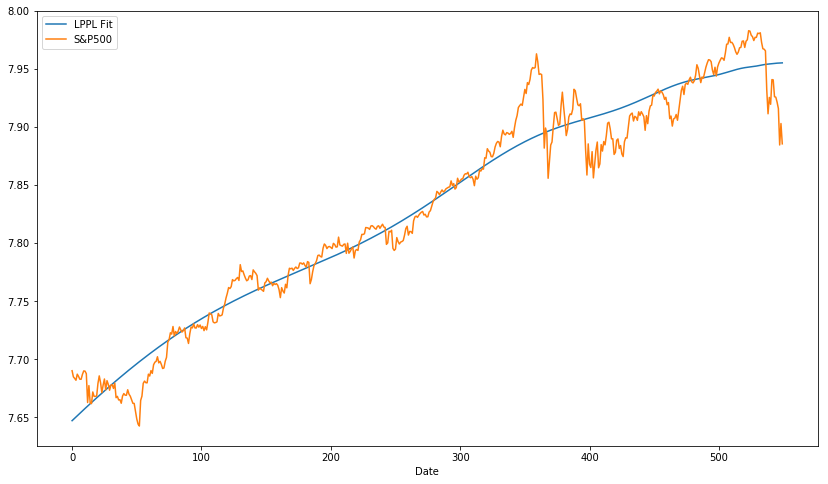

In [116]:
solutions = []

for i in range(126):
    tLen = 750-(i*5)
    tradings_days_data = data.tail(tLen)
    time = np.linspace(0, tLen-1, tLen)
    price = [tradings_days_data["Adj Close"][i] for i in range(len(tradings_days_data["Adj Close"]))]
    data_series = [time, price]
    
    found_solution = False
    

    while not found_solution:
        
        # set limits for non-linear params
        limits = (
            [tLen-(tLen*0.2), tLen+(tLen*0.2)],    # Critical Time + or - .2
            [0.1, 0.9],                            # m : 0.1 ≤ m ≤ 0.9
            [6, 13],                               # ω : 6 ≤ ω ≤ 13     
        )

        # randomly choose vals for non-linear params 
        non_lin_vals = [random.uniform(a[0], a[1]) for a in limits]

        tc = non_lin_vals[0]
        m  = non_lin_vals[1] 
        w  = non_lin_vals[2]

        # params to pass to scipy.optimize
        seed = [tc, m, w]
        
        # scipy optimize minimize
        try:
            cofs = minimize(fun=func_restricted, x0=seed, args=(data_series), method='Nelder-Mead')
            
            if cofs.success:
                # determine if it falls in range:
                
                tc = cofs.x[0]
                m =  cofs.x[1]
                w =  cofs.x[2]
                
                tc_in_range = tLen-(tLen*0.05) < tc < tLen+(tLen*0.1)
                m_in_range  = 0.01 < m < 1.2
                w_in_range  = 2 < w < 25
#                 n_oscillation = (w/2)*np.log((tc - t)/(t2-t))
#                 damping = ""
#                 relative_error = ""
                
                if (tc_in_range and m_in_range and w_in_range):
                    ds_lppls_confidence = True
                else: 
                    ds_lppls_confidence = False

                solutions.append({
                    'ds_lppls_confidence': ds_lppls_confidence,
                    'cof': cofs.x,
                })
                found_solution = True
                
                lin_vals = matrix_equation(tc, m, w, data_series)
    
                a  = lin_vals[0] 
                b  = lin_vals[1]
                c1 = lin_vals[2] 
                c2 = lin_vals[3]
                
                # print it out
                lppl_fit = [lppl(t, tc, m, w, a, b, c1, c2) for t in data_series[0]]
                price_data = data_series[1]

                plot_data = pd.DataFrame({
                    'Date': data_series[0],
                    'LPPL Fit': lppl_fit,
                    'S&P500': np.log(price_data),
                })
                plot_data = plot_data.set_index('Date')
                plot_data.plot(figsize=(14,8))

            print("Success: {}\nMessage: {}".format(cofs.success, cofs.message))
            print("Number of iterations: {}".format(cofs.nit))
            print("Number of evaluations of obj funcs: {}".format(cofs.nfev))
            print("-"*25)

        except Exception as e:
            print(e)

    print("iteration {}: {} trading days".format(i, tLen))
    print(solutions)
    
    